In [9]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.001

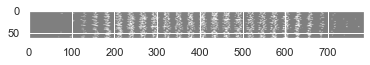

In [12]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [13]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)


    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        return output


In [14]:
model = FCNClass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
opt = "ADAM"

In [15]:
epochs = []
n_total_steps = len(train_loader)
train_loss_average = torch.zeros(num_epochs)
valid_loss_average = torch.zeros(num_epochs)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)
start_time = time.time()

In [ ]:
start_time = time.time()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_valid_loss = 0.0
    #trainng loop
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_step_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_step_loss.backward()
        optimizer.step()

        running_train_loss += train_step_loss.item()

    #get the training losses
    train_loss_average[epoch] = running_train_loss/len(train_loader)

    #validation loop
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        valid_step_loss = criterion(outputs, labels)

        running_valid_loss += valid_step_loss.item()

    #get the validation losses
    valid_loss_average[epoch] = running_valid_loss/len(test_loader)
    epochs.append(epoch)

    #get the current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    #step the learning rate scheduler
    #scheduler.step()

    print(f'Epoch {epoch}\t \
            Training Loss: {running_train_loss/len(train_loader)}\t \
            Validation Loss:{running_valid_loss/len(test_loader)}\t \
            LR:{curr_lr}')

print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')


Epoch 0	             Training Loss: 1.6816361118227179	             Validation Loss:0.6682937076896619	             LR:0.001
Epoch 1	             Training Loss: 1.4893251722301248	             Validation Loss:0.6116628609834962	             LR:0.001
Epoch 2	             Training Loss: 1.4625493141252603	             Validation Loss:0.5894523291451157	             LR:0.001
Epoch 3	             Training Loss: 1.4470515948241707	             Validation Loss:0.5464723526862016	             LR:0.001
Epoch 4	             Training Loss: 1.4379886729376656	             Validation Loss:0.5596309529178461	             LR:0.001
Epoch 5	             Training Loss: 1.4223788499450887	             Validation Loss:0.5279006710287871	             LR:0.001
Epoch 6	             Training Loss: 1.4249761703171964	             Validation Loss:0.5224694394192119	             LR:0.001
Epoch 7	             Training Loss: 1.4210278365149427	             Validation Loss:0.5346499997529255	             LR:0.001


In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')



In [ ]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')

In [ ]:
#plot the loss diagrams
plotLosses(epochs, train_loss_average, f'FCN-{opt}_train_loss lr:{learning_rate} acc:{acc}')
plotLosses(epochs, valid_loss_average, f'FCN-{opt}_valid_loss lr:{learning_rate} acc:{acc}')

plt.figure(figsize=(10,6))
plt.title(f'FCN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f'FCN-{opt} lr:{learning_rate} acc:{acc}.png')


PATH = f'./FCN-{opt}-lr:{learning_rate}-acc:{acc}.pth'
torch.save(model.state_dict(), PATH)